<a href="https://colab.research.google.com/github/superbunny38/MachineLearning/blob/main/Set1Problem1(f)(g)(h).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Libraries
import numpy as np
import pandas as pd
import math
import time
import tqdm as tqdm
import matplotlib.pyplot as plt
import copy
from sklearn.utils import shuffle

**Rights:**

*Assignment made by: Prof. Andrew Ng, Stanford*

*Assignment solved by: Chaeeun Ryu, SKKU*

# 1.(f) 

For Dataset1, create a plot of the training data with $x_1$ on the horizontal axis, and $x_2$ on the vertical axis. To visualize the two classes, use a different symbol for examples $x^{(i)}$ with $y^{(i)}$ = 0 for those with $y^{(i)}$ = 1. On the same figure, plot the decision boundary found by logistic regression in part (b). Make an identical plot with the decision boundary found by GDA in part (e).

In [4]:
train_df1 = pd.read_csv('ds1_train.csv')
train_df1.head()

,x_1,x_2,y
0,2.911809,60.359613,0.0
1,3.774746,344.149284,0.0
2,2.615488,178.222087,0.0
3,2.013694,15.259472,0.0
4,2.757625,66.194174,0.0


In [5]:
#@title util
import matplotlib.pyplot as plt
import numpy as np


def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)

    return inputs, labels


def plot(x, y, theta, save_path=None, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)

def sigmoid(theta, x):
  theta_t = np.transpose(theta)
  z = np.dot(theta_t,x)
  result = 1/(1+np.exp(-z))
  return result

def criterion(h,y):#h: pred, y: actual
  assert len(h) == len(y)
  m = len(h)
  loss = 0.
  for i in range(m):
    loss += -y[i]*math.log(h[i])-(1.-y[i])*math.log(1.-h[i])#BCE
  #print("sum of loss:",loss)
  loss = loss/m
  return loss

def acc(h,y):
  as_labels = []
  for _ in h:
    if _ > 0.5:
      as_labels.append(1.)
    elif _ <= 0.5:
      as_labels.append(0.)
  as_labels, y = np.array(as_labels), np.array(y)
  #print(as_labels)
  return (as_labels == y).sum()/len(as_labels)



## Logistic Regression Implementation

In [6]:
def check_convergence(previous_theta, new_theta):
  eps=1e-5
  dists = []
  for p, n in zip(previous_theta, new_theta):
    dists.append(abs(p-n))
  diff = np.mean(dists)
  print(f"difference between thetas: {diff}")
  if diff < eps:
    return True
  else:
    return False

In [7]:
#linear model
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=[0.,0.,0.], verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        x,y = shuffle(x,y)
        """Run solver to fit linear model.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        assert x.shape[0] ==  y.shape[0]
        

        ###### Find inverse of Hessian
        #derivative of sigmoid
        
        prev_theta = copy.deepcopy(self.theta)
        
        m = x.shape[0]
        Hessians = []
        for j in range(3):
          tmp_H = []
          for k in range(3):
            result_ = 0.
            for i in range(m):
              g = sigmoid(theta = self.theta, x = x[i])
              result_ += g*(1-g)*x[i][j]*x[i][k]
            result_ = result_/m
            tmp_H.append(result_)
          Hessians.append(tmp_H)
        inverse_H = np.linalg.inv(Hessians)
        #print(inverse_H)
        
        ###### Partial derivatives of l(theta) with respect to the theta's
        i,j = 0,0
        partial_d = []#partial d for x_0, x_1, x_2
        for j in range(3):#for all features
          tmp_d = 0. # save partial derivative for each feature
          for i in range(m):
            tmp_d += x[i][j]*(y[i]-sigmoid(theta = self.theta, x = x[i]))
          tmp_d = tmp_d/m
          partial_d.append(tmp_d)
        assert len(partial_d) == x.shape[1]
        #partial_d = np.array(partial_d).reshape(-1,1)
        #print("inverse of Hessian:\n", inverse_H)
        #print("\n\npartial deriv:\n", partial_d)

        update_ = np.matmul(inverse_H, partial_d)

        #calculate loss
        preds = self.predict(x)
        #print("predicted: ",preds[0])
        #print("preds:",preds, "y:",y)
        #print("types:",type(preds), type(y))
        train_loss = criterion(preds, list(y))
        print("train loss: ", train_loss)
        train_acc = acc(preds, list(y))
        print("train acc: ", train_acc)
        #check convergence
        #print("prev:",prev_theta, "new:",update_)
        self.theta = self.theta + update_
        if check_convergence(prev_theta, self.theta) == True:
          print(f"Weights converged. (theta: {self.theta}")
          return True
        return False
        #print(update_)
        #raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        preds = []
        for sample in x:
          #1/(1+np.exp(-z))
          pred = sigmoid(self.theta, sample)
          preds.append(pred)
        return preds
        #raise NotImplementedError('Subclass of LinearModel must implement predict method.')


In [ ]:
#p01b_logreg.py
import numpy as np

def main(train_path = '/content/ds1_train.csv', eval_path = '/content/ds1_valid.csv', pred_path = None):
    """Problem 1(b): Logistic regression with Newton's Method.

    Args:
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    x_train, y_train = load_dataset(train_path, add_intercept=True)
    print(f"train dataset loaded (x with intercept on 0th col: {x_train.shape}, y: {y_train.shape})")
    
    # *** START CODE HERE ***
    print("================Training Starts===========\n")
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    
    print("==============Validation starts===========")
    x_val, y_val = load_dataset(eval_path, add_intercept=True)
  
    print(f"validation dataset loaded (x with intercept on 0th col: {x_val.shape}, y: {y_val.shape})")
    
    pred_val = clf.predict(x_val)
    val_loss = criterion(pred_val, y_val)
    val_acc = acc(pred_val, y_val)
    count = 0
    print("validation loss:",val_loss)
    print("validation acc:",val_acc)

    # *** END CODE HERE ***
    


class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """
    def __init__(self):
      self.model = LinearModel()

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
      
        # *** START CODE HERE ***
        #model = LinearModel()
        model = self.model
        i = 0
        iter = 10
        while i<iter:#True:
          print(f"epoch: {i}")
          check_conv = model.fit(x,y)
          if check_conv == True:
            break
          i += 1
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        return self.model.predict(x)
        # *** END CODE HERE ***

In [ ]:
main()#Logistic Regression

train dataset loaded (x with intercept on 0th col: (800, 3), y: (800,))
================Training Starts===========

epoch: 0
train loss:  0.6931471805599426
train acc:  0.5
difference between thetas: 1.4554742786112016
epoch: 1
train loss:  0.4117763837603567
train acc:  0.86625
difference between thetas: 0.7451431202836653
epoch: 2
train loss:  0.34386418420634207
train acc:  0.8725
difference between thetas: 0.49898465555465216
epoch: 3
train loss:  0.32715319008479665
train acc:  0.88125
difference between thetas: 0.19810485359376348
epoch: 4
train loss:  0.32559133608624186
train acc:  0.8825
difference between thetas: 0.0243566766906724
epoch: 5
train loss:  0.3255719149202474
train acc:  0.8825
difference between thetas: 0.0003263278944413775
epoch: 6
train loss:  0.3255719112349648
train acc:  0.8825
difference between thetas: 6.009403684392733e-08
Weights converged. (theta: [-6.26018491  2.47707251 -0.0299125 ]
==============Validation starts===========
validation dataset loade

In [8]:
logistic_theta = [-6.26018491,  2.47707251, -0.0299125 ]

## Gaussian Discriminant Analysis Implementation

In [9]:
def convert_numpy(x):
  list_ = []
  for _ in x:
    list_.append(np.array(_))
  return list_[0],list_[1],list_[2], list_[3]

In [10]:
import math
def sigmoid(z):
  result = 1/(1+np.exp(-z))
  return result

In [11]:
import numpy as np


def main(train_path = "/content/ds1_train.csv", eval_path = "/content/ds1_valid.csv", pred_path = None):
    """Problem 1(e): Gaussian discriminant analysis (GDA)

    Args:
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    # Load dataset
    x_train, y_train = load_dataset(train_path, add_intercept=False)
    print(f"train dataset loaded (x: {x_train.shape}, y: {y_train.shape})")
    
    # *** START CODE HERE ***
    clf = GDA()
    phi, mu_0, mu_1, sigma = clf.fit(x_train, y_train)
    #print(f"params: {phi, mu_0, mu_1, sigma}")
    predicted=[]
    for x_ in x_train:
      pred = clf.predict(x_)
      predicted.append(pred)
    train_acc = acc(predicted, y_train)
    print(f"train_acc: {train_acc}")




    # Validation dataset
    x_val, y_val = load_dataset(eval_path, add_intercept= False)
    print(f"eval dataset loaded (x: {x_val.shape}, y: {y_val.shape})")
    predicted_val = []
    for x_ in x_val:
      pred = clf.predict(x_)
      predicted_val.append(pred)
    val_acc = acc(predicted_val, y_val)
    print(f"val_acc: {val_acc}")
    
    #return phi, mu_0, mu_1, sigma
    return predicted, predicted_val, clf#predictions for train dset & validation dset
    # *** END CODE HERE ***


class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)

    """
    def __init__(self, phi = None, mu_0 = None, mu_1 = None, sigma = None, theta = None, theta_0 = None):
      self.phi = phi
      self.mu_0 = mu_0
      self.mu_1 = mu_1
      self.sigma = sigma
      self.theta = theta
      self.theta_0 = theta_0

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        # *** START CODE HERE ***
        m = len(y)
        x_train, y_train = x,y
        assert m == x.shape[0]
        phi = np.array(np.where(y_train == 1)).shape[1]/m
        zero_indices = np.array(np.where(y_train == 0))[0]
        mu_0 =np.sum(x_train[zero_indices],axis = 0)/len(np.array(np.where(y_train == 0))[0])
        one_indices = np.array(np.where(y_train == 1))[0]
        mu_1 = np.sum(x_train[one_indices],axis = 0)/len(np.array(np.where(y_train == 1))[0])
        sum_sigma = 0
        for x_, y_ in zip(x, y):
          x_ = np.array(x_)
          if y_ == 1:
            tmp = x_-mu_1
            tmp = np.array(tmp).reshape(-1,1)
            sum_sigma += np.matmul(tmp, tmp.T)
          elif y_ == 0:
            tmp = x_ - mu_0
            tmp = np.array(tmp).reshape(-1,1)
            sum_sigma += np.matmul(tmp, tmp.T)
        sigma = sum_sigma/m
        self.phi = phi
        self.mu_0 = mu_0
        self.mu_1 = mu_1
        self.sigma = sigma
        
  
        return phi, mu_0, mu_1, sigma
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        

        # *** START CODE HERE ***
        phi, mu_0, mu_1, sigma = self.phi, self.mu_0, self.mu_1, self.sigma
        phi, mu_0, mu_1, sigma = convert_numpy([phi, mu_0, mu_1, sigma])
        mu_0, mu_1 = mu_0.reshape(-1,1),mu_1.reshape(-1,1)
       
        theta_transpose = -np.matmul((mu_0 - mu_1).T, np.linalg.inv(sigma))
        #print(f"shapes: {mu_0.T.shape, np.linalg.inv(sigma).shape, mu_0.shape}")
        #print(f"shapes: {mu_1.T.shape, np.linalg.inv(sigma).shape,mu_1.shape}")
        first_matmul = np.matmul(np.matmul(mu_0.T, np.linalg.inv(sigma)), mu_0)
        second_matmul = np.matmul(np.matmul(mu_1.T, np.linalg.inv(sigma)),mu_1)
        #print(f"first matmul: {first_matmul} second matmul: {second_matmul}")
        #print(f"phi: {phi}")
        
        theta_0 = 0.5*(first_matmul-second_matmul)-math.log((1.-phi)/phi)
        x = np.array(x).reshape(-1,1)
        z = np.matmul(theta_transpose,x)+theta_0
        p_1 = sigmoid(z)
        self.theta = theta_transpose.T
        self.theta_0 = theta_0[0]
        #print(f"theta: {theta_transpose.T}, theta0: {theta_0}")
        return p_1
        # *** END CODE HERE

In [ ]:
pred_train, pred_val, gda = main()#GDA

train dataset loaded (x: (800, 2), y: (800,))
train_acc: 0.86625
eval dataset loaded (x: (100, 2), y: (100,))
val_acc: 0.83


In [12]:
train_path = '/content/ds1_train.csv'
eval_path = '/content/ds1_valid.csv'

In [ ]:
x_train, y_train = load_dataset(train_path, add_intercept=False)
x_val, y_val = load_dataset(eval_path, add_intercept= False)

In [ ]:
gda_thetas = np.stack([gda.theta_0[0]]+list(gda.theta.flatten()))
gda_thetas

array([-6.17158405,  2.22055506, -0.01763375])

In [ ]:
x_train, y_train = load_dataset(train_path, add_intercept=True)
x_val, y_val = load_dataset(eval_path, add_intercept=True)

In [ ]:
def plot(x, y, theta = logistic_theta, gda_theta = gda_thetas, save_path=None, correction=1.0, title = ""):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.title(title)
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    
    #logistic regression boundary
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2, label = "LR")

    #gda boundary
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / gda_theta[2] * correction + gda_theta[1] / gda_theta[2] * x1)
    plt.plot(x1, x2, c='pink', linewidth=2, label = "GDA")

    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)
    plt.legend()

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)

# Visualize Results

- LR: train acc:  0.8825
- GDA: train acc: 0.8662

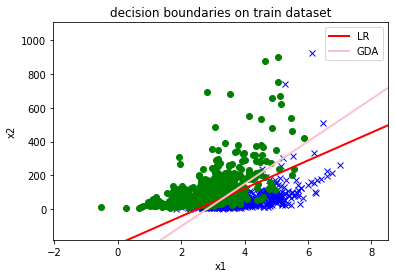

In [ ]:
plot(x_train, y_train, title = "decision boundaries on train dataset")

- LR: val_acc: 0.9
- GDA: val_acc: 0.83

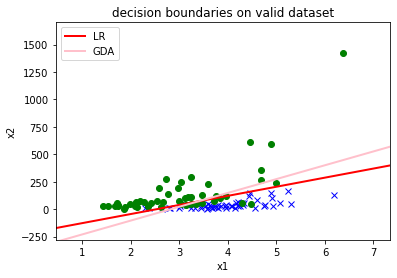

In [ ]:
plot(x_val, y_val, title = "decision boundaries on valid dataset")

# 1.(g) 

Repeat the steps in part (f) for Dataset 2, On which dataset does GDA seem to work worse that logistic regression? Why might be the case?

## Logistic Regression

In [ ]:
#linear model
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=[0.,0.,0.], verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        x,y = shuffle(x,y)
        """Run solver to fit linear model.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        assert x.shape[0] ==  y.shape[0]
        

        ###### Find inverse of Hessian
        #derivative of sigmoid
        
        prev_theta = copy.deepcopy(self.theta)
        
        m = x.shape[0]
        Hessians = []
        for j in range(3):
          tmp_H = []
          for k in range(3):
            result_ = 0.
            for i in range(m):
              g = sigmoid(theta = self.theta, x = x[i])
              result_ += g*(1-g)*x[i][j]*x[i][k]
            result_ = result_/m
            tmp_H.append(result_)
          Hessians.append(tmp_H)
        inverse_H = np.linalg.inv(Hessians)
        #print(inverse_H)
        
        ###### Partial derivatives of l(theta) with respect to the theta's
        i,j = 0,0
        partial_d = []#partial d for x_0, x_1, x_2
        for j in range(3):#for all features
          tmp_d = 0. # save partial derivative for each feature
          for i in range(m):
            tmp_d += x[i][j]*(y[i]-sigmoid(theta = self.theta, x = x[i]))
          tmp_d = tmp_d/m
          partial_d.append(tmp_d)
        assert len(partial_d) == x.shape[1]
        #partial_d = np.array(partial_d).reshape(-1,1)
        #print("inverse of Hessian:\n", inverse_H)
        #print("\n\npartial deriv:\n", partial_d)

        update_ = np.matmul(inverse_H, partial_d)

        #calculate loss
        preds = self.predict(x)
        #print("predicted: ",preds[0])
        #print("preds:",preds, "y:",y)
        #print("types:",type(preds), type(y))
        train_loss = criterion(preds, list(y))
        print("train loss: ", train_loss)
        train_acc = acc(preds, list(y))
        print("train acc: ", train_acc)
        #check convergence
        #print("prev:",prev_theta, "new:",update_)
        self.theta = self.theta + update_
        if check_convergence(prev_theta, self.theta) == True:
          print(f"Weights converged. (theta: {self.theta}")
          return True
        return False
        #print(update_)
        #raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        preds = []
        for sample in x:
          #1/(1+np.exp(-z))
          pred = sigmoid(self.theta, sample)
          preds.append(pred)
        return preds
        #raise NotImplementedError('Subclass of LinearModel must implement predict method.')


In [ ]:
#p01b_logreg.py
import numpy as np

def main(train_path = '/content/ds2_train.csv', eval_path = '/content/ds2_valid.csv', pred_path = None):
    """Problem 1(b): Logistic regression with Newton's Method.

    Args:
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    x_train, y_train = load_dataset(train_path, add_intercept=True)
    print(f"train dataset loaded (x with intercept on 0th col: {x_train.shape}, y: {y_train.shape})")
    
    # *** START CODE HERE ***
    print("================Training Starts===========\n")
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    
    print("==============Validation starts===========")
    x_val, y_val = load_dataset(eval_path, add_intercept=True)
  
    print(f"validation dataset loaded (x with intercept on 0th col: {x_val.shape}, y: {y_val.shape})")
    
    pred_val = clf.predict(x_val)
    val_loss = criterion(pred_val, y_val)
    val_acc = acc(pred_val, y_val)
    count = 0
    print("validation loss:",val_loss)
    print("validation acc:",val_acc)

    # *** END CODE HERE ***
    


class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """
    def __init__(self):
      self.model = LinearModel()

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
      
        # *** START CODE HERE ***
        #model = LinearModel()
        model = self.model
        i = 0
        iter = 10
        while i<iter:#True:
          print(f"epoch: {i}")
          check_conv = model.fit(x,y)
          if check_conv == True:
            break
          i += 1
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        return self.model.predict(x)
        # *** END CODE HERE ***

In [ ]:
main()#Logistic Regression

train dataset loaded (x with intercept on 0th col: (800, 3), y: (800,))
================Training Starts===========

epoch: 0
train loss:  0.6931471805599426
train acc:  0.5
difference between thetas: 1.150780468912868
epoch: 1
train loss:  0.30897679688997937
train acc:  0.91375
difference between thetas: 0.8004771998224035
epoch: 2
train loss:  0.22984552562488086
train acc:  0.915
difference between thetas: 0.7207139230139052
epoch: 3
train loss:  0.20550760595803208
train acc:  0.915
difference between thetas: 0.4613206994308981
epoch: 4
train loss:  0.20103088010308304
train acc:  0.915
difference between thetas: 0.13557600775136494
epoch: 5
train loss:  0.2007930051019603
train acc:  0.915
difference between thetas: 0.00900101133180146
epoch: 6
train loss:  0.2007920783675635
train acc:  0.915
difference between thetas: 3.685590210415294e-05
epoch: 7
train loss:  0.200792078351712
train acc:  0.915
difference between thetas: 6.258679500585155e-10
Weights converged. (theta: [ 2.384

In [ ]:
logistic_theta = [ 2.38425454,  3.6371206,  -3.81234337]

## Gaussian Discriminant Analysis

In [40]:
import math
def sigmoid(z):
  result = 1/(1+np.exp(-z))
  return result

In [ ]:
import numpy as np


def main(train_path = "/content/ds2_train.csv", eval_path = "/content/ds2_valid.csv", pred_path = None):
    """Problem 1(e): Gaussian discriminant analysis (GDA)

    Args:
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    # Load dataset
    x_train, y_train = load_dataset(train_path, add_intercept=False)
    print(f"dataset names: {train_path, eval_path}")
    print(f"train dataset loaded (x: {x_train.shape}, y: {y_train.shape})")
    
    # *** START CODE HERE ***
    clf = GDA()
    phi, mu_0, mu_1, sigma = clf.fit(x_train, y_train)
    #print(f"params: {phi, mu_0, mu_1, sigma}")
    predicted=[]
    for x_ in x_train:
      pred = clf.predict(x_)
      predicted.append(pred)
    train_acc = acc(predicted, y_train)
    print(f"train_acc: {train_acc}")




    # Validation dataset
    x_val, y_val = load_dataset(eval_path, add_intercept= False)
    print(f"eval dataset loaded (x: {x_val.shape}, y: {y_val.shape})")
    predicted_val = []
    for x_ in x_val:
      pred = clf.predict(x_)
      predicted_val.append(pred)
    val_acc = acc(predicted_val, y_val)
    print(f"val_acc: {val_acc}")
    
    #return phi, mu_0, mu_1, sigma
    return predicted, predicted_val, clf#predictions for train dset & validation dset
    # *** END CODE HERE ***


class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)

    """
    def __init__(self, phi = None, mu_0 = None, mu_1 = None, sigma = None, theta = None, theta_0 = None):
      self.phi = phi
      self.mu_0 = mu_0
      self.mu_1 = mu_1
      self.sigma = sigma
      self.theta = theta
      self.theta_0 = theta_0

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        # *** START CODE HERE ***
        m = len(y)
        x_train, y_train = x,y
        assert m == x.shape[0]
        phi = np.array(np.where(y_train == 1)).shape[1]/m
        zero_indices = np.array(np.where(y_train == 0))[0]
        mu_0 =np.sum(x_train[zero_indices],axis = 0)/len(np.array(np.where(y_train == 0))[0])
        one_indices = np.array(np.where(y_train == 1))[0]
        mu_1 = np.sum(x_train[one_indices],axis = 0)/len(np.array(np.where(y_train == 1))[0])
        sum_sigma = 0
        for x_, y_ in zip(x, y):
          x_ = np.array(x_)
          if y_ == 1:
            tmp = x_-mu_1
            tmp = np.array(tmp).reshape(-1,1)
            sum_sigma += np.matmul(tmp, tmp.T)
          elif y_ == 0:
            tmp = x_ - mu_0
            tmp = np.array(tmp).reshape(-1,1)
            sum_sigma += np.matmul(tmp, tmp.T)
        sigma = sum_sigma/m
        self.phi = phi
        self.mu_0 = mu_0
        self.mu_1 = mu_1
        self.sigma = sigma
        
  
        return phi, mu_0, mu_1, sigma
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        

        # *** START CODE HERE ***
        phi, mu_0, mu_1, sigma = self.phi, self.mu_0, self.mu_1, self.sigma
        phi, mu_0, mu_1, sigma = convert_numpy([phi, mu_0, mu_1, sigma])
        mu_0, mu_1 = mu_0.reshape(-1,1),mu_1.reshape(-1,1)
       
        theta_transpose = -np.matmul((mu_0 - mu_1).T, np.linalg.inv(sigma))
        #print(f"shapes: {mu_0.T.shape, np.linalg.inv(sigma).shape, mu_0.shape}")
        #print(f"shapes: {mu_1.T.shape, np.linalg.inv(sigma).shape,mu_1.shape}")
        first_matmul = np.matmul(np.matmul(mu_0.T, np.linalg.inv(sigma)), mu_0)
        second_matmul = np.matmul(np.matmul(mu_1.T, np.linalg.inv(sigma)),mu_1)
        #print(f"first matmul: {first_matmul} second matmul: {second_matmul}")
        #print(f"phi: {phi}")
        
        theta_0 = 0.5*(first_matmul-second_matmul)-math.log((1.-phi)/phi)
        x = np.array(x).reshape(-1,1)
        z = np.matmul(theta_transpose,x)+theta_0
        p_1 = sigmoid(z)
        self.theta = theta_transpose.T
        self.theta_0 = theta_0[0]
        #print(f"theta: {theta_transpose.T}, theta0: {theta_0}")
        return p_1
        # *** END CODE HERE

In [ ]:
pred_train, pred_val, gda = main()#GDA

dataset names: ('/content/ds2_train.csv', '/content/ds2_valid.csv')
train dataset loaded (x: (800, 2), y: (800,))
train_acc: 0.91375
eval dataset loaded (x: (100, 2), y: (100,))
val_acc: 0.91


In [ ]:
gda_thetas = np.stack([gda.theta_0[0]]+list(gda.theta.flatten()))
gda_thetas

array([ 2.50874989,  3.76951271, -3.94657107])

# Visualize Results

In [ ]:
train_path = '/content/ds2_train.csv'
eval_path = '/content/ds2_valid.csv'
x_train, y_train = load_dataset(train_path, add_intercept=False)
x_val, y_val = load_dataset(eval_path, add_intercept= False)

- LR: train acc: 0.915
- GDA: train acc: 0.91375

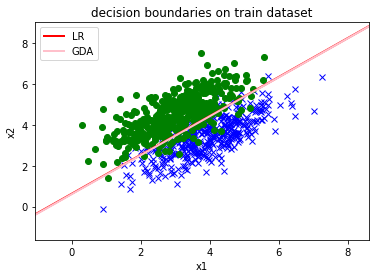

In [ ]:
plot(x_train, y_train, title = "decision boundaries on train dataset")

- LR: val acc: 0.91
- GDA: val acc: 0.91

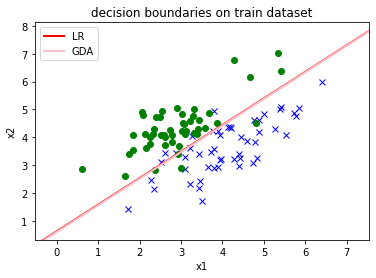

In [ ]:
plot(x_val, y_val, title = "decision boundaries on train dataset")

# (g) Answers in text

On dataset1, the GDA seems to perform worse than logistic regression. It might be because $p(x|y)$ for dataset1 is not represented well by gaussian distribution compared to the dataset2.

# (h)
For the dataset where GDA performed worse in parts (f) and (g), can you find a transformation of the $x^{(i)}$'s such that GDA performs better? What is the transformation?

In [13]:
train_path = '/content/ds1_train.csv'
eval_path = '/content/ds1_valid.csv'

In [43]:
train_df = pd.read_csv(train_path)
eval_df = pd.read_csv(eval_path)

In [18]:
pd.read_csv(train_path).head()

,x_1,x_2,y
0,2.911809,60.359613,0.0
1,3.774746,344.149284,0.0
2,2.615488,178.222087,0.0
3,2.013694,15.259472,0.0
4,2.757625,66.194174,0.0


In [14]:
x_train, y_train = load_dataset(train_path, add_intercept=False)
x_val, y_val = load_dataset(eval_path, add_intercept= False)

## Tried Standard Normalization (-> no improvement)

In [17]:
#normalization?
x_train.shape

(800, 2)

In [25]:
mean_x1 = np.mean(x_train[:,0])
mean_x2 = np.mean(x_train[:,1])
std_x1 = np.std(x_train[:,0])
std_x2 = np.std(x_train[:,1])

In [26]:
normalized_x = []
for (x1,x2) in x_train:
  tmp_row = [(x1-mean_x1)/std_x1, (x2-mean_x2)/std_x2]
  normalized_x.append(tmp_row)

In [28]:
np.array(normalized_x).shape

(800, 2)

In [29]:
normalized_x = np.array(normalized_x)

In [33]:
train_normalized_df = pd.DataFrame({'x_1':normalized_x[:,0], 'x_2':normalized_x[:,1], 'y':y_train})

In [34]:
train_normalized_df.to_csv('normalized_ds1_train.csv', index = False)

In [35]:
normalized_val_x = []
for (x1,x2) in x_val:
  tmp_row = [(x1-mean_x1)/std_x1, (x2-mean_x2)/std_x2]
  normalized_val_x.append(tmp_row)

In [36]:
normalized_val_x = np.array(normalized_val_x)

In [37]:
valid_normalized_df = pd.DataFrame({'x_1':normalized_val_x[:,0], 'x_2':normalized_val_x[:,1], 'y':y_val})

In [38]:
valid_normalized_df.head()

,x_1,x_2,y
0,-1.198903,-0.124093,0.0
1,0.390822,0.270661,0.0
2,-0.147485,-0.395495,0.0
3,-1.290683,-0.577921,0.0
4,0.057284,1.177416,0.0


In [39]:
valid_normalized_df.to_csv('normalized_ds1_val.csv', index = False)

In [41]:
import numpy as np


def main(train_path = "/content/normalized_ds1_train.csv", eval_path = "/content/normalized_ds1_val.csv", pred_path = None):
    """Problem 1(e): Gaussian discriminant analysis (GDA)

    Args:
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    # Load dataset
    x_train, y_train = load_dataset(train_path, add_intercept=False)
    print(f"dataset names: {train_path, eval_path}")
    print(f"train dataset loaded (x: {x_train.shape}, y: {y_train.shape})")
    
    # *** START CODE HERE ***
    clf = GDA()
    phi, mu_0, mu_1, sigma = clf.fit(x_train, y_train)
    #print(f"params: {phi, mu_0, mu_1, sigma}")
    predicted=[]
    for x_ in x_train:
      pred = clf.predict(x_)
      predicted.append(pred)
    train_acc = acc(predicted, y_train)
    print(f"train_acc: {train_acc}")




    # Validation dataset
    x_val, y_val = load_dataset(eval_path, add_intercept= False)
    print(f"eval dataset loaded (x: {x_val.shape}, y: {y_val.shape})")
    predicted_val = []
    for x_ in x_val:
      pred = clf.predict(x_)
      predicted_val.append(pred)
    val_acc = acc(predicted_val, y_val)
    print(f"val_acc: {val_acc}")
    
    #return phi, mu_0, mu_1, sigma
    return predicted, predicted_val, clf#predictions for train dset & validation dset
    # *** END CODE HERE ***


class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)

    """
    def __init__(self, phi = None, mu_0 = None, mu_1 = None, sigma = None, theta = None, theta_0 = None):
      self.phi = phi
      self.mu_0 = mu_0
      self.mu_1 = mu_1
      self.sigma = sigma
      self.theta = theta
      self.theta_0 = theta_0

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        # *** START CODE HERE ***
        m = len(y)
        x_train, y_train = x,y
        assert m == x.shape[0]
        phi = np.array(np.where(y_train == 1)).shape[1]/m
        zero_indices = np.array(np.where(y_train == 0))[0]
        mu_0 =np.sum(x_train[zero_indices],axis = 0)/len(np.array(np.where(y_train == 0))[0])
        one_indices = np.array(np.where(y_train == 1))[0]
        mu_1 = np.sum(x_train[one_indices],axis = 0)/len(np.array(np.where(y_train == 1))[0])
        sum_sigma = 0
        for x_, y_ in zip(x, y):
          x_ = np.array(x_)
          if y_ == 1:
            tmp = x_-mu_1
            tmp = np.array(tmp).reshape(-1,1)
            sum_sigma += np.matmul(tmp, tmp.T)
          elif y_ == 0:
            tmp = x_ - mu_0
            tmp = np.array(tmp).reshape(-1,1)
            sum_sigma += np.matmul(tmp, tmp.T)
        sigma = sum_sigma/m
        self.phi = phi
        self.mu_0 = mu_0
        self.mu_1 = mu_1
        self.sigma = sigma
        
  
        return phi, mu_0, mu_1, sigma
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        

        # *** START CODE HERE ***
        phi, mu_0, mu_1, sigma = self.phi, self.mu_0, self.mu_1, self.sigma
        phi, mu_0, mu_1, sigma = convert_numpy([phi, mu_0, mu_1, sigma])
        mu_0, mu_1 = mu_0.reshape(-1,1),mu_1.reshape(-1,1)
       
        theta_transpose = -np.matmul((mu_0 - mu_1).T, np.linalg.inv(sigma))
        #print(f"shapes: {mu_0.T.shape, np.linalg.inv(sigma).shape, mu_0.shape}")
        #print(f"shapes: {mu_1.T.shape, np.linalg.inv(sigma).shape,mu_1.shape}")
        first_matmul = np.matmul(np.matmul(mu_0.T, np.linalg.inv(sigma)), mu_0)
        second_matmul = np.matmul(np.matmul(mu_1.T, np.linalg.inv(sigma)),mu_1)
        #print(f"first matmul: {first_matmul} second matmul: {second_matmul}")
        #print(f"phi: {phi}")
        
        theta_0 = 0.5*(first_matmul-second_matmul)-math.log((1.-phi)/phi)
        x = np.array(x).reshape(-1,1)
        z = np.matmul(theta_transpose,x)+theta_0
        p_1 = sigmoid(z)
        self.theta = theta_transpose.T
        self.theta_0 = theta_0[0]
        #print(f"theta: {theta_transpose.T}, theta0: {theta_0}")
        return p_1
        # *** END CODE HERE

In [42]:
pred_train, pred_val, gda = main()#GDA

dataset names: ('/content/normalized_ds1_train.csv', '/content/normalized_ds1_val.csv')
train dataset loaded (x: (800, 2), y: (800,))
train_acc: 0.86625
eval dataset loaded (x: (100, 2), y: (100,))
val_acc: 0.83


## Check skewness

 -0.5 < skewness < 0.5 are symmetric i.e normally distributed

In [45]:
train_df.skew()

x_1    0.096205
x_2    3.423625
y      0.000000
dtype: float64

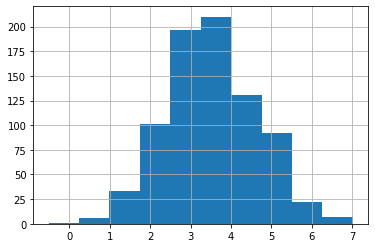

In [47]:
train_df.x_1.hist()

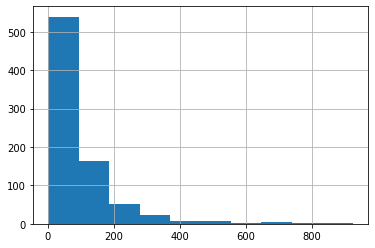

In [48]:
train_df.x_2.hist()

In [49]:
import scipy.stats as stats
import pylab

((array([-3.13269090e+00, -2.86240960e+00, -2.71124085e+00, -2.60445496e+00,
         -2.52103830e+00, -2.45216961e+00, -2.39327695e+00, -2.34167369e+00,
         -2.29564214e+00, -2.25401521e+00, -2.21596250e+00, -2.18087139e+00,
         -2.14827658e+00, -2.11781604e+00, -2.08920237e+00, -2.06220345e+00,
         -2.03662904e+00, -2.01232119e+00, -1.98914727e+00, -1.96699480e+00,
         -1.94576754e+00, -1.92538245e+00, -1.90576741e+00, -1.88685932e+00,
         -1.86860270e+00, -1.85094845e+00, -1.83385292e+00, -1.81727714e+00,
         -1.80118612e+00, -1.78554840e+00, -1.77033549e+00, -1.75552160e+00,
         -1.74108324e+00, -1.72699897e+00, -1.71324918e+00, -1.69981586e+00,
         -1.68668245e+00, -1.67383370e+00, -1.66125548e+00, -1.64893473e+00,
         -1.63685932e+00, -1.62501798e+00, -1.61340021e+00, -1.60199621e+00,
         -1.59079683e+00, -1.57979349e+00, -1.56897816e+00, -1.55834331e+00,
         -1.54788184e+00, -1.53758709e+00, -1.52745276e+00, -1.51747292e+00,

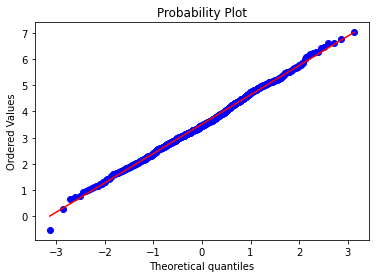

In [50]:
stats.probplot(train_df.x_1,plot=pylab)

((array([-3.13269090e+00, -2.86240960e+00, -2.71124085e+00, -2.60445496e+00,
         -2.52103830e+00, -2.45216961e+00, -2.39327695e+00, -2.34167369e+00,
         -2.29564214e+00, -2.25401521e+00, -2.21596250e+00, -2.18087139e+00,
         -2.14827658e+00, -2.11781604e+00, -2.08920237e+00, -2.06220345e+00,
         -2.03662904e+00, -2.01232119e+00, -1.98914727e+00, -1.96699480e+00,
         -1.94576754e+00, -1.92538245e+00, -1.90576741e+00, -1.88685932e+00,
         -1.86860270e+00, -1.85094845e+00, -1.83385292e+00, -1.81727714e+00,
         -1.80118612e+00, -1.78554840e+00, -1.77033549e+00, -1.75552160e+00,
         -1.74108324e+00, -1.72699897e+00, -1.71324918e+00, -1.69981586e+00,
         -1.68668245e+00, -1.67383370e+00, -1.66125548e+00, -1.64893473e+00,
         -1.63685932e+00, -1.62501798e+00, -1.61340021e+00, -1.60199621e+00,
         -1.59079683e+00, -1.57979349e+00, -1.56897816e+00, -1.55834331e+00,
         -1.54788184e+00, -1.53758709e+00, -1.52745276e+00, -1.51747292e+00,

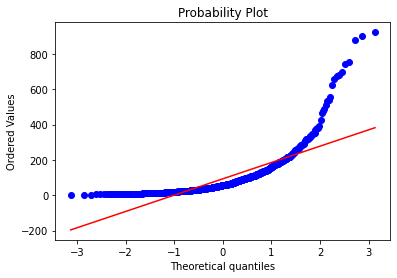

In [51]:
stats.probplot(train_df.x_2,plot=pylab)

shows that x_2 is not normally distributed

## Log transformation on x_2

In [53]:
new_x2 = np.log(train_df['x_2'])

In [55]:
log_train_df = pd.DataFrame({'x_1':train_df['x_1'], 'x_2':new_x2, 'y':train_df['y']})

In [56]:
log_train_df.to_csv('log_train.csv', index = False)

In [ ]:
new_val_x2 = np.log()